<IPython.core.display.Javascript object>


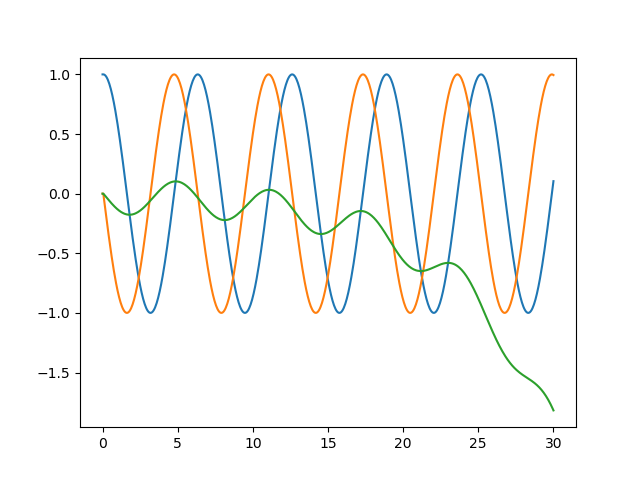

In [27]:
%matplotlib notebook
import numpy 
from matplotlib import pyplot 

def matrix_exponential(A):
    L, P = numpy.linalg.eig(A)
    D    = numpy.diag(numpy.exp(L))
    B    = P.dot(D).dot(numpy.linalg.inv(P))  
    return(B)

def integrate(A, h, t0, tf, x0):
    xs = [x0]
    ts = [t0]
    t  = t0
    
    while t < tf:
        B = matrix_exponential(A*t)
        x = numpy.real(B.dot(x0))
        h = min(h, tf - t)
        t = t + h
        
        xs.append(x)
        ts.append(t)
        
    return ts, xs

    
A  = numpy.array([[0, 1, 0],[-1, 0, 0],[-.15, 0, .15]])
x0 = numpy.array([1, 0, 0])

ts, xs = integrate(A, 0.05, 0, 30, x0)
pyplot.figure()
pyplot.plot(ts, xs)


<IPython.core.display.Javascript object>


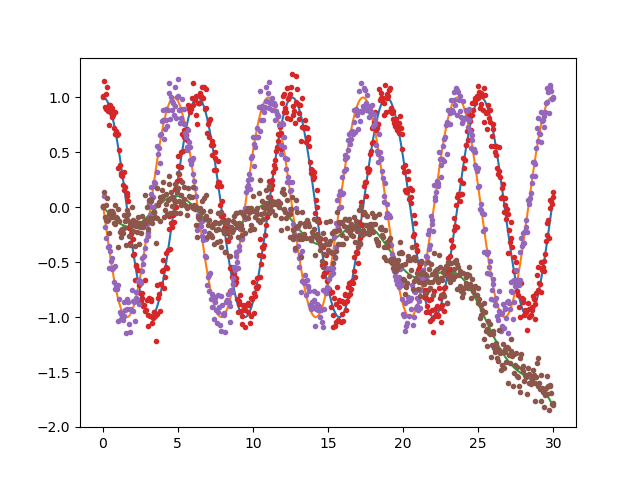

In [31]:
class KalmanFilter(object):
    
    # A    : model matrix
    # M    : model matrix integrated over time
    # H    : observation operator
    # K    : Kalman gain
    # x0   : initial guess of state variable
    # xf   : forecast state variable
    # xa   : analysis state variable
    # Pf   : forecast/initial state error covariance matrix of 
    # Q    : model error covariance matrix (unbiased, uncorrelated noise)
    # R    : observation covariance matrix (unbiased, uncorrelated noise)
    # t0   : initial time
    # tf   : final time
    # h    : timestep
    # dims : number of dimensions of state variable
    

    def __init__(self, A, H):
        self.A = A
        self.H = H
        
    def compute_analysis(self, x0, Pf, Q, R, t0, tf, h, dims):
        A = self.A
        H = self.H
        xs = [x0]
        ts = [t0]
        xf = x0
        t  = t0
        
        while t < tf:
            K = Pf.dot(H.T).dot(numpy.linalg.inv(H.dot(Pf).dot(H.T) + R)) # computing Kalman gain 
            M = matrix_exponential(A*t)
            y = numpy.real(M.dot(x0)) + numpy.random.randn()*.1           # generating observation with white noise
            
            xa = xf + K.dot(y - H.dot(xf))                                # computing analysis vector
            Pa = (numpy.eye(dims) - K.dot(H)).dot(Pf)                     # computing analysis error covariance
            Pf = M.dot(Pa).dot(M.T) + Q                                   # computing forecast covariance
            t  = t + h
            
            xs.append(xa.real)
            ts.append(t)
            
        return ts, xs
    
H  = numpy.eye(3)
KF = KalmanFilter(A, H)

x0 = numpy.array([1, 0, 0])
Pf = numpy.array([[0.1, 0, 0],[0, 0.1, 0],[0, 0, 0.1]])
Q  = numpy.array([[0.5, 0, 0],[0, 0.5, 0],[0, 0, 0.5]])
R  = numpy.array([[0.01, 0, 0],[0, 0.01, 0],[0, 0, 0.01]])


ts, xs_KF = KF.compute_analysis(x0, Pf, Q, R, 0, 30, .05, 3)

pyplot.figure()
pyplot.plot(ts, xs, ts, xs_KF, '.')
            